# AI Diary
This notebook demonstrates:
1. Dataset loading and preprocessing
2. A domain-specific BERT baseline (ClinicalBERT)
3. A transformer-based prototype (RoBERTa)
4. Model evaluation and comparison

**NOTE:**
This is an INTERIM prototype (IPD)
Models are trained lightly for feasibility, not optimisation


In [1]:
# ======================================================
# AI Diary Project — Emotion Detection (IPD)


# Core system utilities
import os
import glob
from zipfile import ZipFile

# Data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Deep learning / NLP
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Hugging Face dataset helper
from datasets import Dataset

# Disable external logging tools
os.environ["WANDB_DISABLED"] = "true"


In [2]:
# ======================================================
# Dataset Upload and Extraction


from google.colab import files

uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
os.makedirs("goemotions", exist_ok=True)

with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("goemotions")


Saving DATA final year .zip to DATA final year .zip


In [3]:
# ======================================================
# Locate and Load Dataset Files


def find_file(pattern):
    matches = glob.glob(pattern, recursive=True)
    if not matches:
        raise FileNotFoundError(f"No file: {pattern}")
    return matches[0]

train_path = find_file("goemotions/**/train.tsv")
emotions_path = find_file("goemotions/**/emotions.txt")

train_df = pd.read_csv(
    train_path,
    sep="\t",
    names=["text", "labels", "id"]
)

with open(emotions_path, encoding="utf-8") as f:
    emotions = [line.strip() for line in f if line.strip()]

print("Samples:", len(train_df))
print("Emotion:", len(emotions))


Samples: 43410
Emotion: 28


In [4]:
# ======================================================
# Dataset Subsampling (IPD Justification)


train_small = train_df.sample(5000, random_state=42).reset_index(drop=True)
NUM_EMOTIONS = len(emotions)

print("Subset size:", len(train_small))


Subset size: 5000


In [5]:
# ======================================================
# Label Encoding (Multi-label → Multi-hot)


def encode_labels(label_string):
    vector = np.zeros(NUM_EMOTIONS)
    for label in str(label_string).split(","):
        if label.isdigit():
            vector[int(label)] = 1
    return vector

train_small["label_vector"] = train_small["labels"].apply(encode_labels)


In [6]:
# ======================================================
# Train/Test Split


X_train, X_test, y_train, y_test = train_test_split(
    train_small["text"],
    np.stack(train_small["label_vector"]),
    test_size=0.2,
    random_state=42
)


In [7]:
# ======================================================
# Evaluation Metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Apply sigmoid to logits
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Use LOWER threshold for IPD
    predictions = (probs >= 0.3).astype(int)

    return {
        "macro_f1": f1_score(labels, predictions, average="macro", zero_division=0),
        "micro_f1": f1_score(labels, predictions, average="micro", zero_division=0),
    }


In [8]:
# ======================================================
# Baseline Model — Domain-Specific BERT (ClinicalBERT)


CLINICAL_BERT = "emilyalsentzer/Bio_ClinicalBERT"

clinical_tokenizer = AutoTokenizer.from_pretrained(CLINICAL_BERT)

def tokenize_clinical(batch):
    return clinical_tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

clinical_train_ds = Dataset.from_dict({
    "text": X_train.tolist(),
    "labels": y_train.tolist()
})

clinical_test_ds = Dataset.from_dict({
    "text": X_test.tolist(),
    "labels": y_test.tolist()
})

clinical_train_ds = clinical_train_ds.map(tokenize_clinical, batched=True)
clinical_test_ds = clinical_test_ds.map(tokenize_clinical, batched=True)

clinical_train_ds.set_format("torch")
clinical_test_ds.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
# ======================================================
# ClinicalBERT Model Configuration

clinical_model = AutoModelForSequenceClassification.from_pretrained(
    CLINICAL_BERT,
    num_labels=NUM_EMOTIONS,
    problem_type="multi_label_classification"
)

clinical_args = TrainingArguments(
    output_dir="clinicalbert_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    save_strategy="no",
    report_to="none"
)

clinical_trainer = Trainer(
    model=clinical_model,
    args=clinical_args,
    train_dataset=clinical_train_ds,
    eval_dataset=clinical_test_ds,
    tokenizer=clinical_tokenizer,
    compute_metrics=compute_metrics
)

clinical_trainer.train()
clinical_metrics = clinical_trainer.evaluate()

print("ClinicalBERT Performance:", clinical_metrics)



pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2142975285.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  clinical_trainer = Trainer(


Step,Training Loss
500,0.171800


ClinicalBERT Performance: {'eval_loss': 0.1455601155757904, 'eval_macro_f1': 0.021128005657708625, 'eval_micro_f1': 0.2882991556091677, 'eval_runtime': 7.9425, 'eval_samples_per_second': 125.906, 'eval_steps_per_second': 15.738, 'epoch': 1.0}


In [10]:
# ======================================================
# Tokenisation using RoBERTa


roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_roberta(batch):
    return roberta_tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = Dataset.from_dict({"text": X_train.tolist(), "labels": y_train.tolist()})
test_ds = Dataset.from_dict({"text": X_test.tolist(), "labels": y_test.tolist()})

train_ds = train_ds.map(tokenize_roberta, batched=True)
test_ds = test_ds.map(tokenize_roberta, batched=True)

train_ds.set_format("torch")
test_ds.set_format("torch")



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
# ======================================================
# RoBERTa Model Configuration


roberta_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=NUM_EMOTIONS,
    problem_type="multi_label_classification"
)

roberta_args = TrainingArguments(
    output_dir="roberta_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    save_strategy="no",
    report_to="none"
)

roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=roberta_tokenizer,
    compute_metrics=compute_metrics
)

roberta_trainer.train()

roberta_metrics = roberta_trainer.evaluate()

print("RoBERTa Performance:", roberta_metrics)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3690285031.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


Step,Training Loss
500,0.167400


RoBERTa Performance: {'eval_loss': 0.1492966264486313, 'eval_macro_f1': 0.01776322850703016, 'eval_micro_f1': 0.3035304906006419, 'eval_runtime': 6.4489, 'eval_samples_per_second': 155.066, 'eval_steps_per_second': 19.383, 'epoch': 1.0}


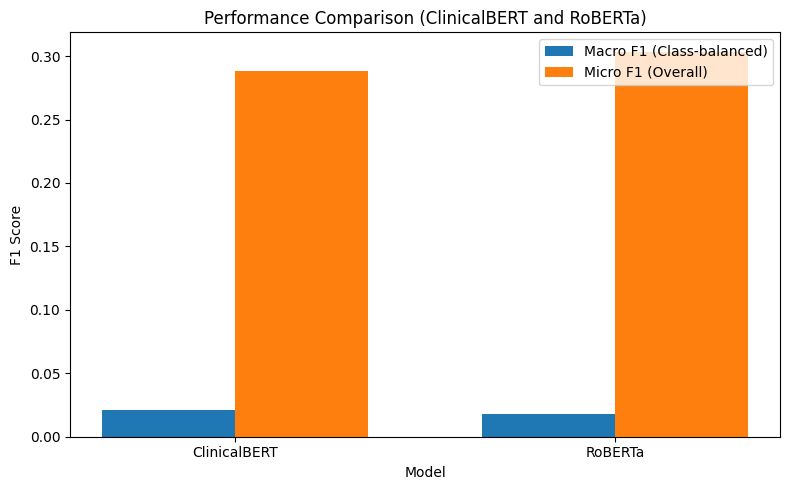

In [12]:
# ======================================================
# Model Performance Comparison (Interim Results)


models = ["ClinicalBERT", "RoBERTa"]

macro_f1 = [
    clinical_metrics["eval_macro_f1"],
    roberta_metrics["eval_macro_f1"]
]

micro_f1 = [
    clinical_metrics["eval_micro_f1"],
    roberta_metrics["eval_micro_f1"]
]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))

plt.bar(
    x - width/2,
    macro_f1,
    width,
    label="Macro F1 (Class-balanced)"
)

plt.bar(
    x + width/2,
    micro_f1,
    width,
    label="Micro F1 (Overall)"
)

plt.xticks(x, models)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.title(
    "Performance Comparison (ClinicalBERT and RoBERTa)"
)

plt.legend()
plt.tight_layout()
plt.show()
